<img src = "https://drive.google.com/uc?export=view&id=1z-EW8gVlIg4Zcp_HvN-BElP0KknNnfML" alt = "Encabezado MLDS" width = "100%">  </img>

# **Análisis de series de tiempo con redes neuronales**
---
En este material se presentarán las redes neuronales y, en particular, la implementación de un perceptrón multicapa con *Scikit-Learn*. Además, y para poner a prueba este tipo de modelo, se planteará un problema de análisis de series de tiempo, y se entrenará y evaluará un modelo para este proceso.

# **1. Dependencias**
---
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en algunos ejemplos.


### **1.1. Dependencias**
---
Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería **Scikit-learn** (**`sklearn`**) y varias de sus funciones y conjuntos de datos.

In [22]:
# Actualizamos scikit-learn a la última versión
# !pip install -U scikit-learn

# Importamos scikit-learn
import sklearn

Importamos además algunas librerías básicas y configuraciones de *Python*.

In [23]:
# Librerías básicas NumPy, Pandas, Matplotlib y Seaborn.
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt

In [24]:
# Configuraciones para las librerías y módulos usados.

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)

Utilizaremos *Plotly* para generar visualizaciones interactivas.

In [25]:
# !pip install -U plotly
import plotly
import plotly.graph_objects as go

Este material se realizó con las siguientes versiones:
*  *Python*: 3.7.10
*  *Scikit-learn*: 0.24.1
*  *NumPy*:  1.19.5
*  *Pandas*:  1.1.5
*  *Matplotlib*:  3.2.2
*  *Seaborn*:  0.11.1
*  *Plotly*: 4.14.3

In [26]:
# Versión de Python y las demás librerías.
!python --version
print('Scikit-learn', sklearn.__version__)
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)
print('Plotly', plotly.__version__)

Python 3.11.5Scikit-learn 1.3.1
NumPy 1.26.0
Pandas 2.1.1
Matplotlib 3.8.0
Seaborn 0.13.0
Plotly 5.17.0



### **1.2. Funciones de utilidad y visualización**
---

Para ilustrar los ejemplos discutidos en este material utilizaremos algunas funciones que permiten visualizar de manera general los datos, junto a las funciones de predicción obtenidas con cada modelo.

> **Nota**: *Matplotlib* y *Seaborn* se encuentran por fuera del alcance de este módulo. No es necesario que entienda estas funciones en detalle para sacar partido del resto del contenido puesto a su disposición. Usted decide si leer o no estas funciones en profundidad. Si decide omitir esta sección, continúe directamente con la siguiente sección, en donde se discutirán los conjuntos de datos que vamos a utilizar.

In [27]:
# Función para visualizar un conjunto de datos de dos variables en un plano 2D.
def plot_data(X, y, model = None, ax = None, title=None):

    if ax is None:
      _, ax = plt.subplots(dpi = 110)

    if model is not None:
      pred_fun = gen_pred_fun(model)
      plot_decision_region(X, pred_fun, ax)

    y_unique = np.unique(y)
    df = pd.DataFrame({'x1': X[:,0], 'x2': X[:,1], 'Clases': y})
    sns.set_theme()
    sns.scatterplot(data = df, x = 'x1', y = 'x2',
                    hue = 'Clases',style = 'Clases', ax = ax, palette = 'Set1').set_title(title)

In [28]:
# Función para visualizar la superficie de decisión de un clasificador.
def plot_decision_region(X, pred_fun, ax=None):
    min_x, max_x = np.min(X[:, 0]), np.max(X[:, 0])
    min_y, max_y = np.min(X[:, 1]), np.max(X[:, 1])

    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05

    x_vals = np.linspace(min_x, max_x, 100)
    y_vals = np.linspace(min_y, max_y, 100)

    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape

    ZZ = np.zeros((grid_r, grid_c))

    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])

    cs = ax.contourf(XX, YY, ZZ, 100, cmap = plt.cm.Pastel1, vmin = 0, vmax = np.max(ZZ)* 9. / (np.max(ZZ) + 1), alpha = 0.75)
    ax.get_figure().colorbar(cs, ax=ax, )
    ax.set_xlabel("x")
    ax.set_ylabel("y")

In [29]:
#Función para generar la función de predicción de un clasificador entrenado previamente.
def gen_pred_fun(clf):
    def pred_fun(x1, x2):
        x = np.array([[x1, x2]])
        return clf.predict(x)[0]
    return pred_fun

In [30]:
# Gráficar la predicción de los datos de temperatura.

def plot_prediction(params, ys, test_date_index):

  train_data = mintemp.loc[:test_date_index[0]]
  _y_test, _y_forward, _y_last = ys
  # Graficamos los valores predichos.
  fig = go.Figure(layout = dict(
       title = f'<b>Temperaturas medias semanales (1981-1990)</b> <br> {params}',
       dragmode= 'pan', width = 1200, height = 600))

  fig.add_trace(go.Scatter(x = train_data.index,  # Datos originales hasta la primer semana predicha. (fechas)
                          y = train_data.values, # Datos originales hasta la primer semana predicha. (temperaturas)
                          mode = 'lines',
                          name = 'Valores de entrenamiento y pruebas'))

  #Gráfica de los valores de prueba reales.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_test,
                          mode='lines+markers',
                          name='Valores reales (y)'))


  #Gráfica de los valores predichos a partir de las ventanas de X_test.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_forward,
                          mode = 'lines+markers',
                          name = 'Valores predichos a partir de datos reales'))

  #Gráfica de los valores predichos a partir de ventanas creadas proceduralmente.
  fig.add_trace(go.Scatter(x = test_date_index,
                          y = _y_last,
                          mode='lines+markers',
                          name='Valores predichos a partir de datos predichos'))

  fig.show(config = dict({'scrollZoom': True}))

# **2. Conjuntos de datos**
---

Para los ejemplos desarrollados en el transcurso de material, se usarán datos de  *Scikit-Learn* de carácter real (usando *Loaders*) y sintético (usando *Generators*).

## **2.1. Conjunto de datos *Iris***
---

En este material retomaremos el conjunto de datos *Iris* para ilustrar algunos ejemplos. Para esto, usaremos la función **`load_iris`** de *Scikit-Learn*.

In [31]:
# Loader del dataset iris
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data
y = iris.target

In [32]:
# Información general del conjunto.

print(f'X ~ {X.shape[0]} muestras x {X.shape[1]} características.')
print(f'y ~ {y.shape[0]} muestras.')
print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:\n', y[:5])

X ~ 150 muestras x 4 características.
y ~ 150 muestras.

Primeras 5 muestras:
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]

Primeras 5 etiquetas:
 [0 0 0 0 0]


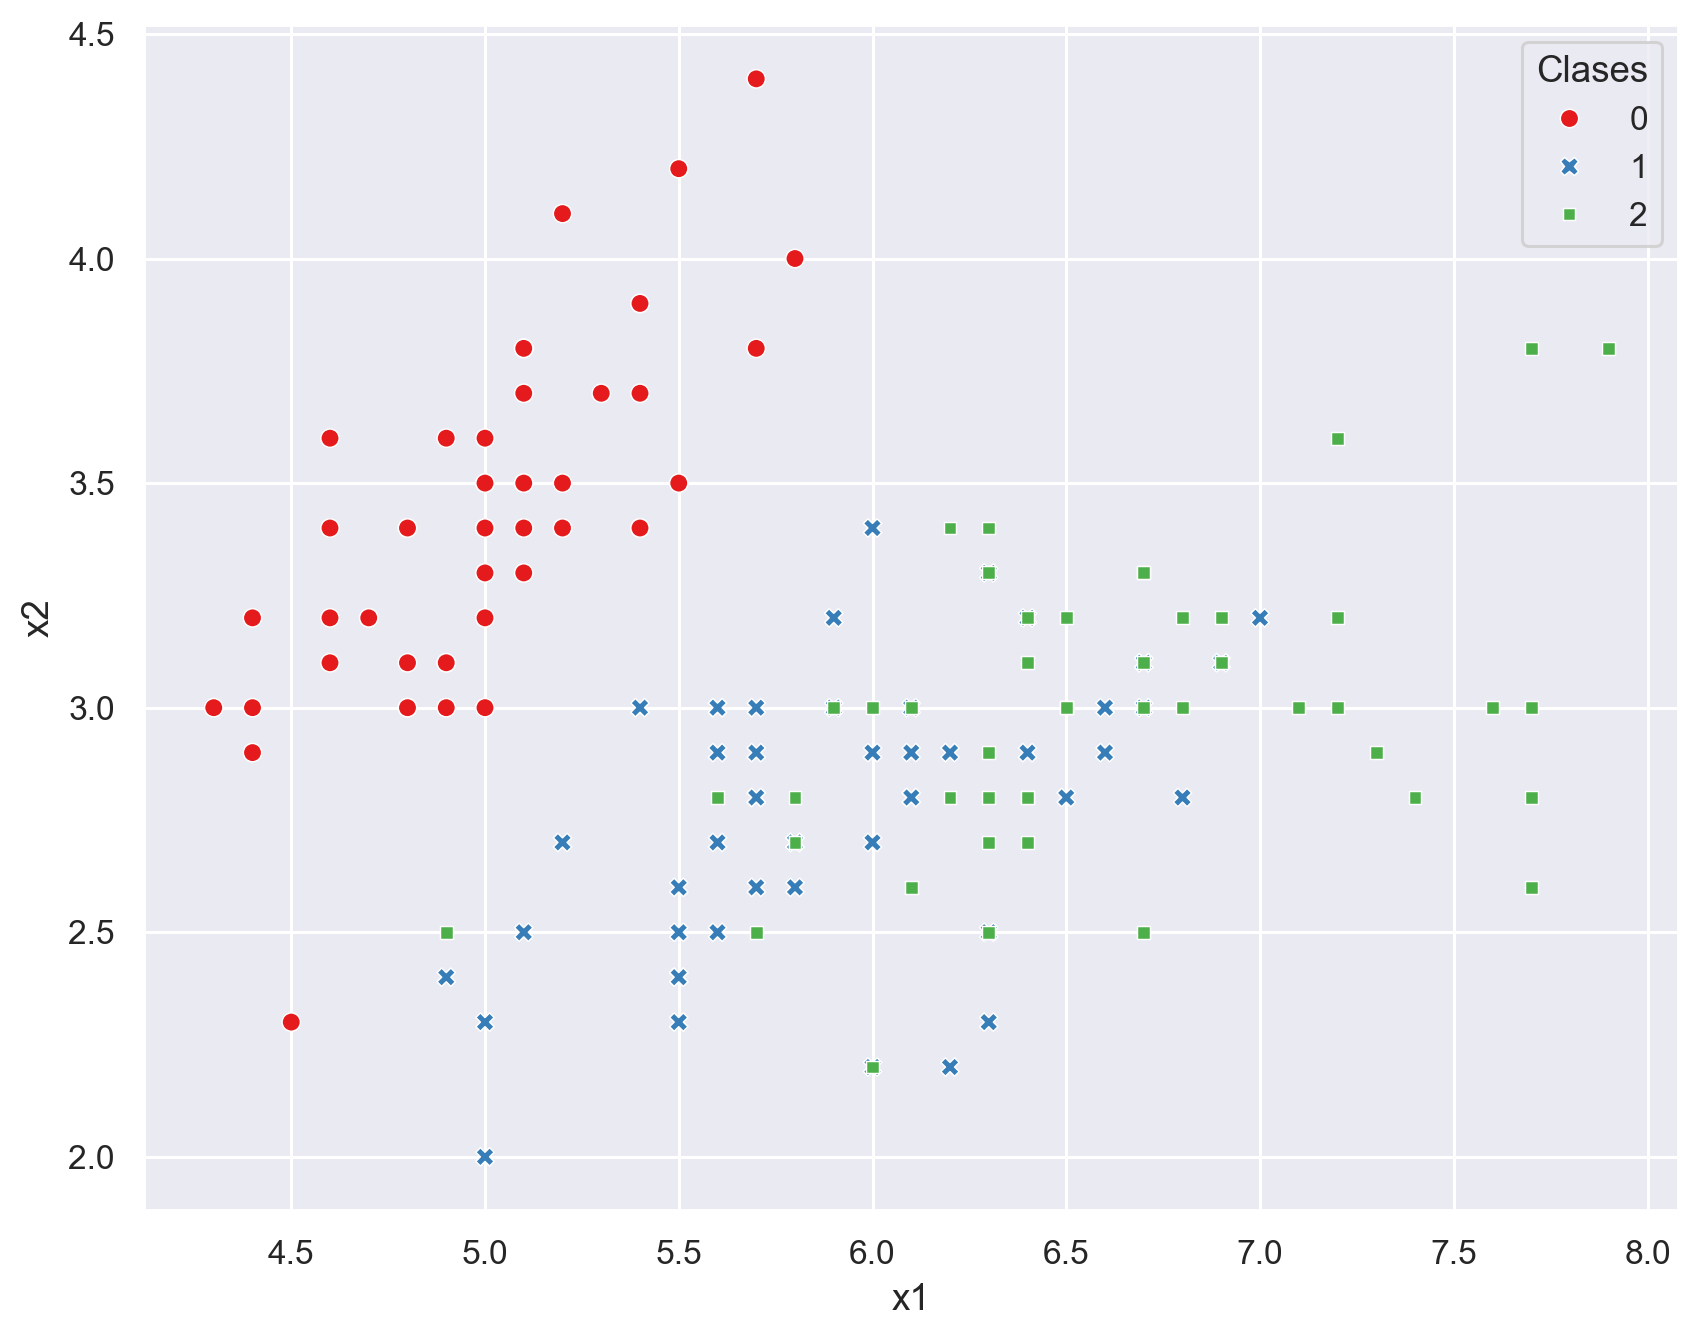

In [33]:
#Graficamos en un área 2d
plot_data(X, y)

## **2.2. Conjunto de datos sintético**
---
Además de *Iris*, vamos a trabajar con el conjunto de datos artificiales ***moons***. Para cargarlo usaremos la siguiente función:

  * **`make_moons`**: Este conjunto de datos artificial genera dos variables asociadas a dos clases que representan dos medias lunas. *Scikit-Learn* permite a su vez introducir algo de ruido sobre las muestras creadas.


In [34]:
# Conjunto de datos sintético moons.
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=600,
                    noise=0.1,
                    random_state=0)

In [35]:
# Información general del conjunto.
print(f'X ~ {X.shape[0]} muestras x {X.shape[1]} características.')
print(f'y ~ {y.shape[0]} muestras.')
print('\nPrimeras 5 muestras:\n', X[:5, :])
print('\nPrimeras 5 etiquetas:\n', y[:5])

X ~ 600 muestras x 2 características.
y ~ 600 muestras.

Primeras 5 muestras:
 [[ 0.79376821 -0.51480339]
 [ 0.24846934  0.97421613]
 [-0.6473948   0.74392718]
 [ 1.22860278 -0.596126  ]
 [-0.41419323  0.76579368]]

Primeras 5 etiquetas:
 [1 0 0 1 0]


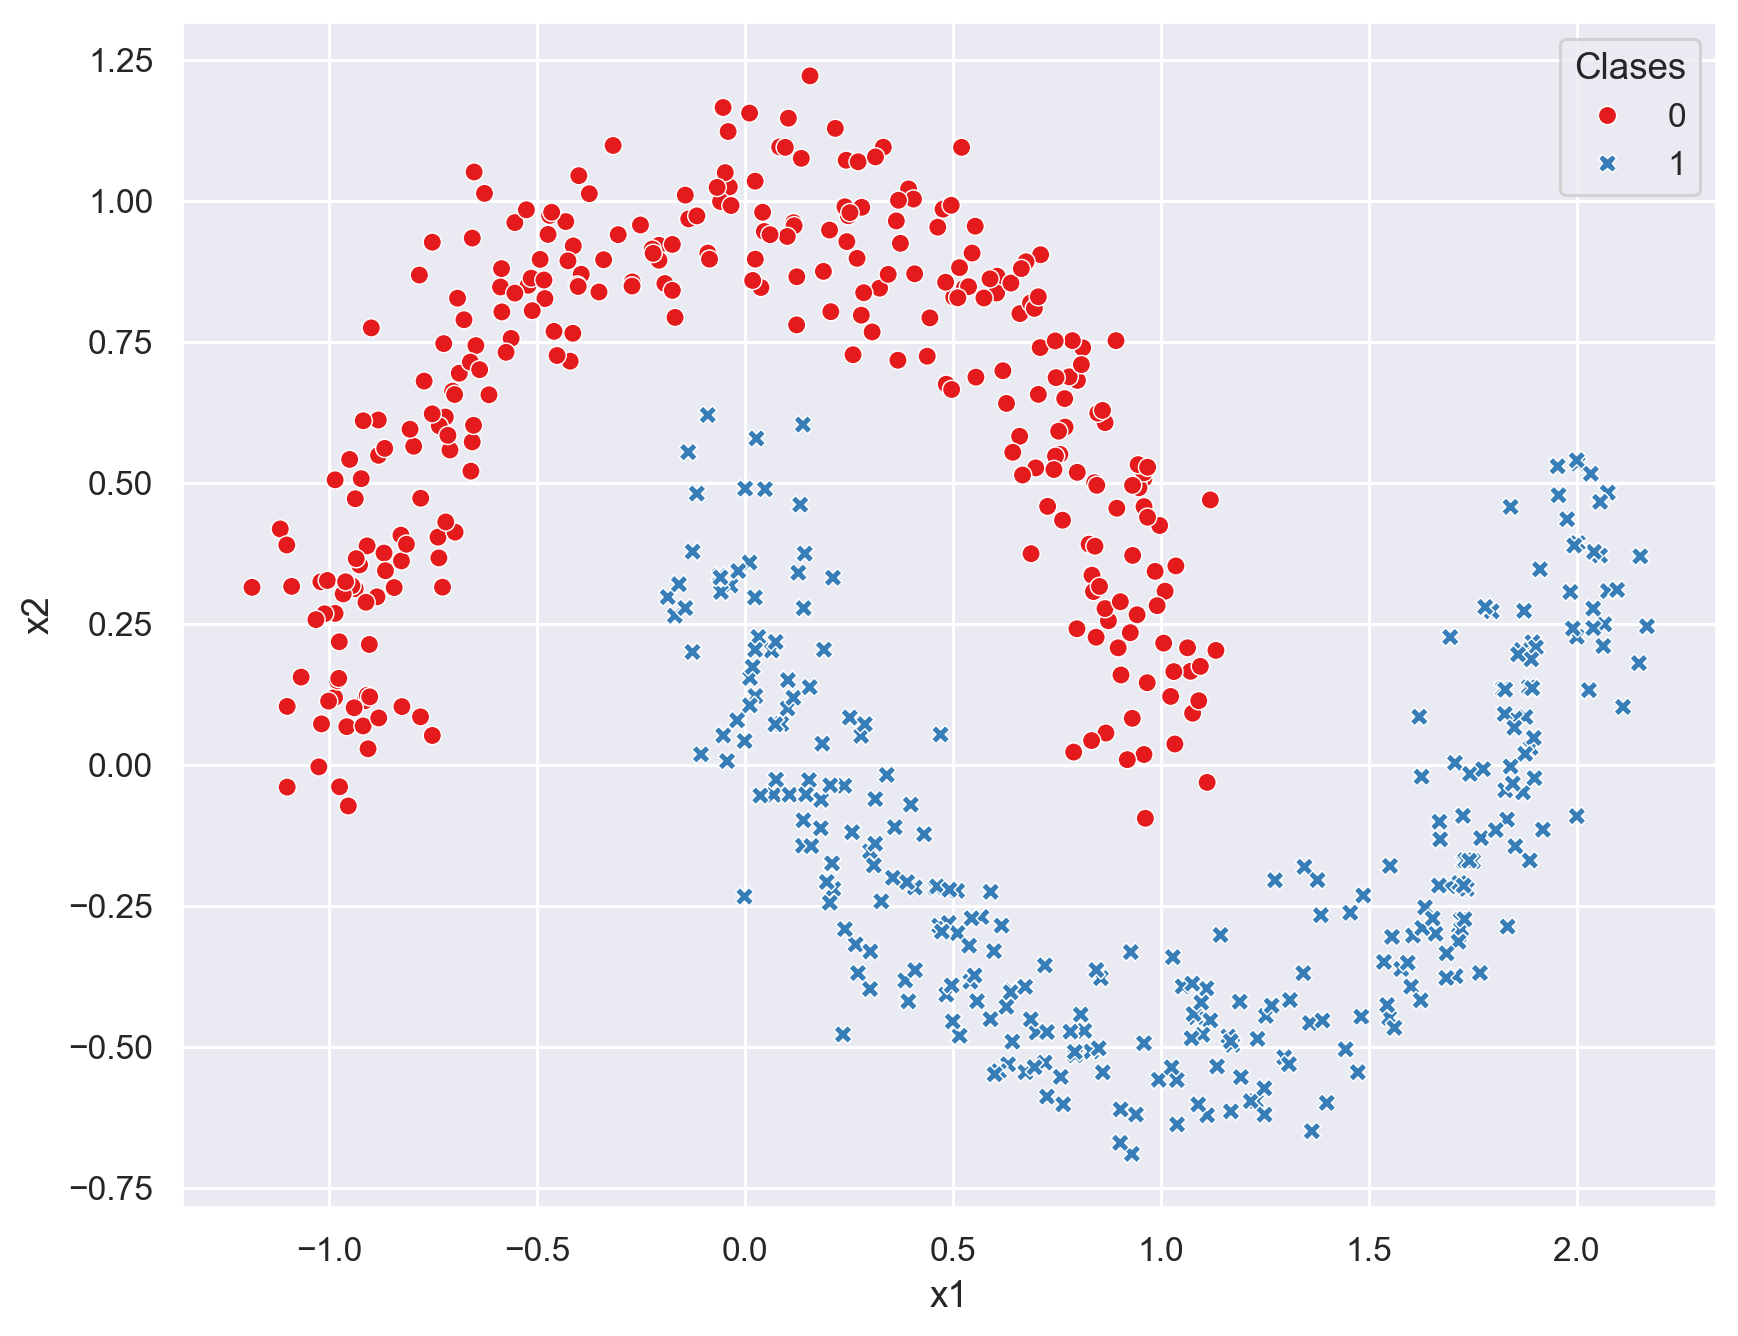

In [36]:
# Graficamos en un área 2d.
plot_data(X, y)

## **2.3. Conjunto de datos de temperaturas mínimas diarias**
---

Para este material, en la sección de análisis de series de tiempo, utilizaremos el *dataset* [***Minimum Daily Temperatures***](https://www.kaggle.com/paulbrabban/daily-minimum-temperatures-in-melbourne). Este *dataset* almacena la temperatura mínima diaria (C°) en la ciudad de Melbourne, Australia en un periodo de 10 años, desde 1981 hasta 1990. En esta ocasión usaremos una versión distinta, que toma las medias semanales de temperatura mínima de estos datos.

> Estos datos fueron tomados del siguiente enlace de [*Machine Learning Mastery*](https://github.com/jbrownlee/Datasets/blob/master/README.md), reprocesados con las medias semanales y fueron recopilados originalmente por *Australian Bureau of Meteorology*. La siguiente celda descarga el archivo:

In [37]:
#@markdown **Ejecute esta celda para descargar el archivo en una serie.**

url = 'https://drive.google.com/uc?export=download&id=1XvKsdBs6EG463iN3L1lQv9JXd9lW0JJC'

mintemp = pd.read_csv(url, index_col=0, parse_dates=True)
mintemp.head()

,Temp
Date,
1981-01-01,20.700000
1981-01-08,16.585714
1981-01-15,19.214286
1981-01-22,18.514286
1981-01-29,16.814286


# **3. Red neuronal artificial**
---

El perceptrón multicapa (*Multilayer Perceptron*, MLP en inglés) es un tipo especial de red neuronal artificial en el cual se apilan varias capas de neuronas artificiales o perceptrones. En inglés también se le denomina como ***Feedforward neural network***.

El perceptrón multicapa está motivado por la poca capacidad del perceptrón sencillo de modelar funciones no lineales. En un *MLP* agrupamos tantas capas como necesitemos.
<center>
<img src="https://drive.google.com/uc?export=view&id=1DFV06d4-aMlCrXAiCuzOgB_0zbptGJI6" align="middle">
</center>

Una red neuronal multicapa está generalmente conformada por:

* **Capa de entrada:** recibe los datos de entrada.
* **Capa oculta:** cuenta con una o más neuronas.
* **Capa de activación:** aplica una función de activación sobre la salida de cada neurona de la capa oculta.
* **Cada de salida:** produce la predicción para completar la tarea supervisada. Puede ser de clasificación o regresión.



## **3.1. Implementación con *Scikit-Learn***
---

*Scikit-Learn* nos permite trabajar con redes de perceptrones multicapa usando **`sklearn.neural_network.MLPClassifier`**. Una red multicapa se puede entrenar usando **gradiente descendente**, y por tanto, se pueden usar métodos como **gradiente descendente estocástico** (**`sgd`**) u otros métodos de optimización. Cómo se describió en materiales anteriores, el valor del gradiente determina qué tanto debo modificar los pesos de la red o parámetros entrenables para resolver la tarea de predicción.


**`MLPClassifier`** permite definir esta arquitectura de la siguiente manera:

* **Capa de entrada**: El tamaño de la capa de entrada es definido cuando se llama a la función **`fit()`**. El tamaño está definido por el número de características (o columnas) de la matriz de características `X`.
* **Capa(s) ocultas**: El número de capas ocultas y el tamaño de cada una es definido por el parámetro **`hidden_layer_size`** de la clase **`MLPClassifier`**. Este parámetro consiste en una tupla de $n$ elementos, donde $n$ es igual al número de capas ocultas. Cada elemento de la tupla determina el número de neuronas de esa capa oculta.
* **Función de activación**: Esta función se define usando el parámetro **`activation`**. Este parámetro puede tomar como valor las cadenas de texto **`logistic`**, **`relu`**, **`tanh`** o **`identity`**.

**`Visualización de las funciones de activación posibles`:**


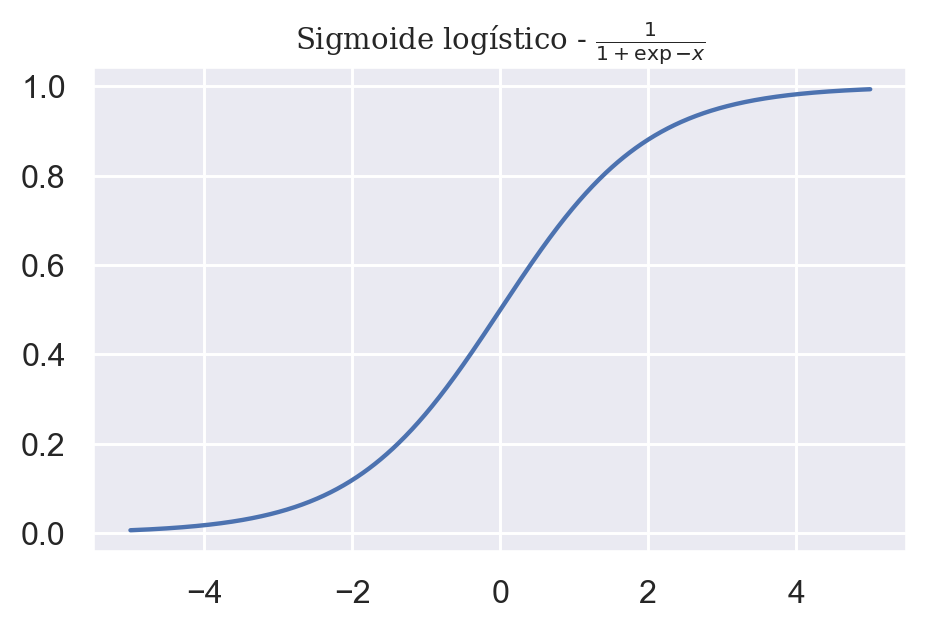

In [53]:
title = r'Sigmoide logístico - $\frac{1}{1 + \exp{-x}}$'

x = np.linspace(-5,5, 1000)
logistic = 1 / (1 + np.exp(-x))

font = {'family': 'serif',
        'weight': 'normal',
        'size': 10}

fig, ax = plt.subplots(figsize = (5, 3), dpi = 105)
ax.plot(x, logistic); ax.set_title(title, fontdict= font);

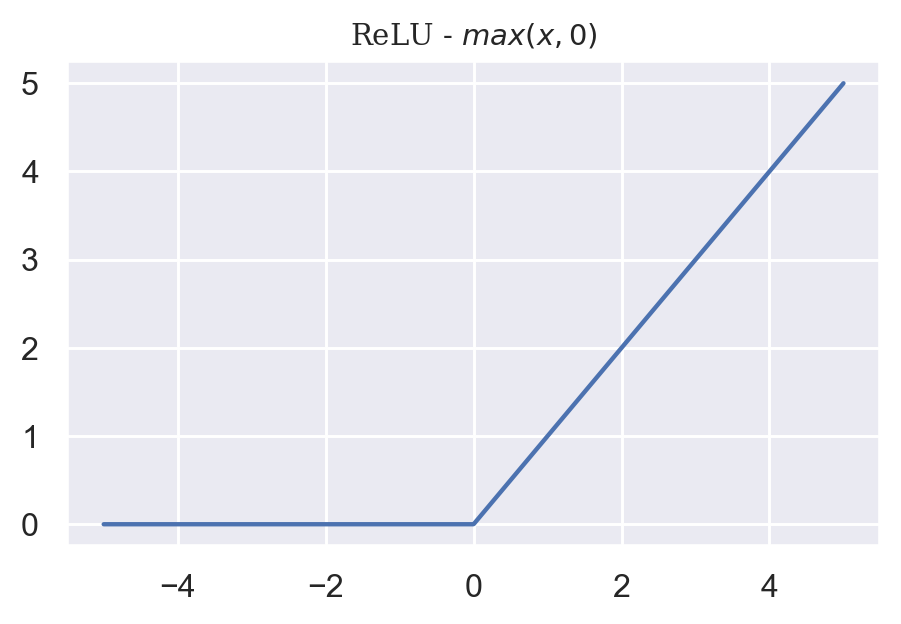

In [52]:
title = r'ReLU - $max(x, 0)$'

x = np.linspace(-5,5, 1000)
relu = np.maximum(0, x)

font = {'family': 'serif',
        'weight': 'normal',
        'size': 10}

fig, ax = plt.subplots(figsize = (5, 3), dpi = 105)
ax.plot(x, relu); ax.set_title(title, fontdict= font);

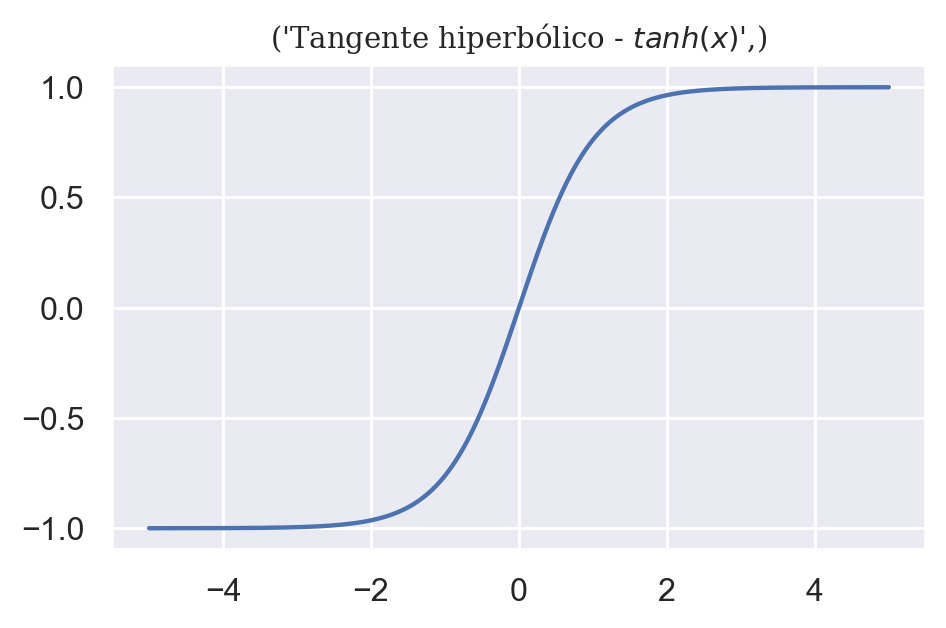

In [54]:
title = 'Tangente hiperbólico - $tanh(x)$',

x = np.linspace(-5,5, 1000)
tanh = np.tanh(x)

font = {'family': 'serif',
        'weight': 'normal',
        'size': 10}

fig, ax = plt.subplots(figsize = (5, 3), dpi = 105)
ax.plot(x, tanh); ax.set_title(title, fontdict= font);

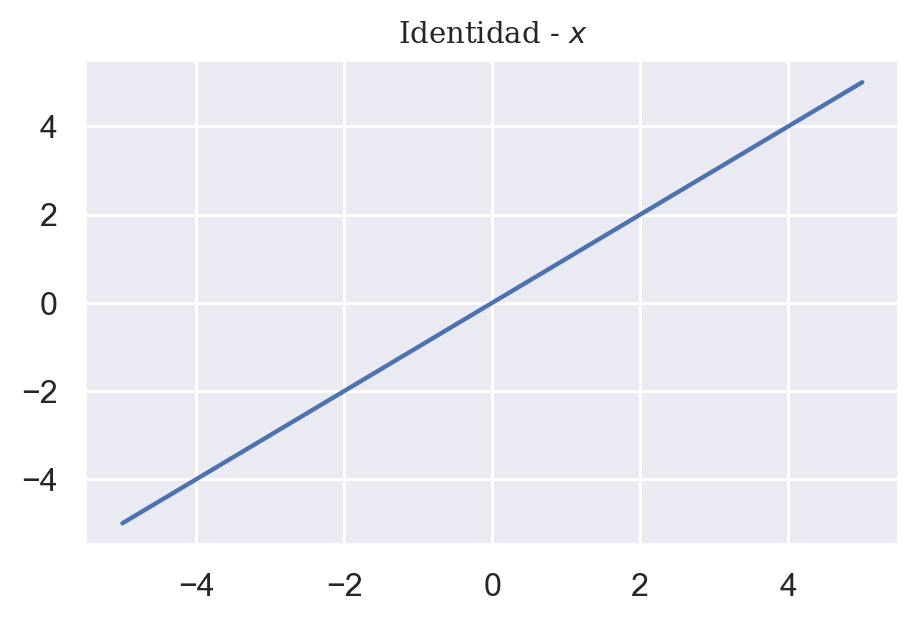

In [55]:
title = 'Identidad - $x$'

x = np.linspace(-5,5, 1000)
identity = x

font = {'family': 'serif',
        'weight': 'normal',
        'size': 10}

fig, ax = plt.subplots(figsize = (5, 3), dpi = 105)
ax.plot(x, identity); ax.set_title(title, fontdict= font);

* **Capa de salida**: Se define cuando se llama a la función **`fit()`**. La capa de salida contiene una única neurona, cuya función de activación se define con base al tipo de tarea de clasificación. Si es una tarea de clasificación binaria usa una función de activación logística. Si la tarea es multiclase se usa una función de activación *SoftMax*.

Adicionalmente **`MLPClassifier`** recibe los siguientes parámetros:

* **`solver`**: Puede ser **`lbfgs`**, **`sgd`** o **`adam`**. El *solver* *lbfgs* es una técnica de optimización muy útil para conjuntos pequeños, mientras que *sgd* y *adam* usan gradiente descendente estocástico y son apropiados para conjuntos de datos grandes.
* **`alpha`**: El parámetro $\alpha$ representa el parámetro de regularización y permite penalizar aquellos pesos $w$ grandes.

In [56]:
# Cargamos los datos en formato X, y
iris = load_iris()
X_iris = iris.data[:,[0, 2]]
y_iris = iris.target

X_moons, y_moons = make_moons(n_samples=600,   # Número de observaciones o muestras.
                              noise=0.15,      # Cantidad de ruido aleatorio introducido.
                              random_state=0)  # Semilla aleatoria para garantizar la replicabilidad.

In [57]:
# Clasificador basado en una red neuronal multicapa.
from sklearn.neural_network import MLPClassifier

# Clasificador para el conjunto Iris
clf_iris = MLPClassifier(solver='sgd', # Descenso del gradiente estocástico.
                    learning_rate='constant', # Tipo de tasa de aprendizaje.
                    learning_rate_init=0.001, # Tasa de aprendizaje inicial.
                    activation='relu', # Función de activación.
                                       # En este caso se usa la función de rectificación
                                       # lineal uniforme "y = max(0, x)"
                    max_iter=1000, # Iteraciones máximas
                    tol= 1e-4,          # Valor de tolerancia de la optimización.
                    hidden_layer_sizes=(10, 10)) # Tamaño de las capas ocultas.

In [58]:
# Entrenamiento del modelo. Este proceso puede tardar.

clf_iris.fit(X_iris, y_iris)

MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, solver='sgd')

Podemos observar la evolución del error de entrenamiento durante el proceso de optimización usando el atributo **`loss_curve`**.

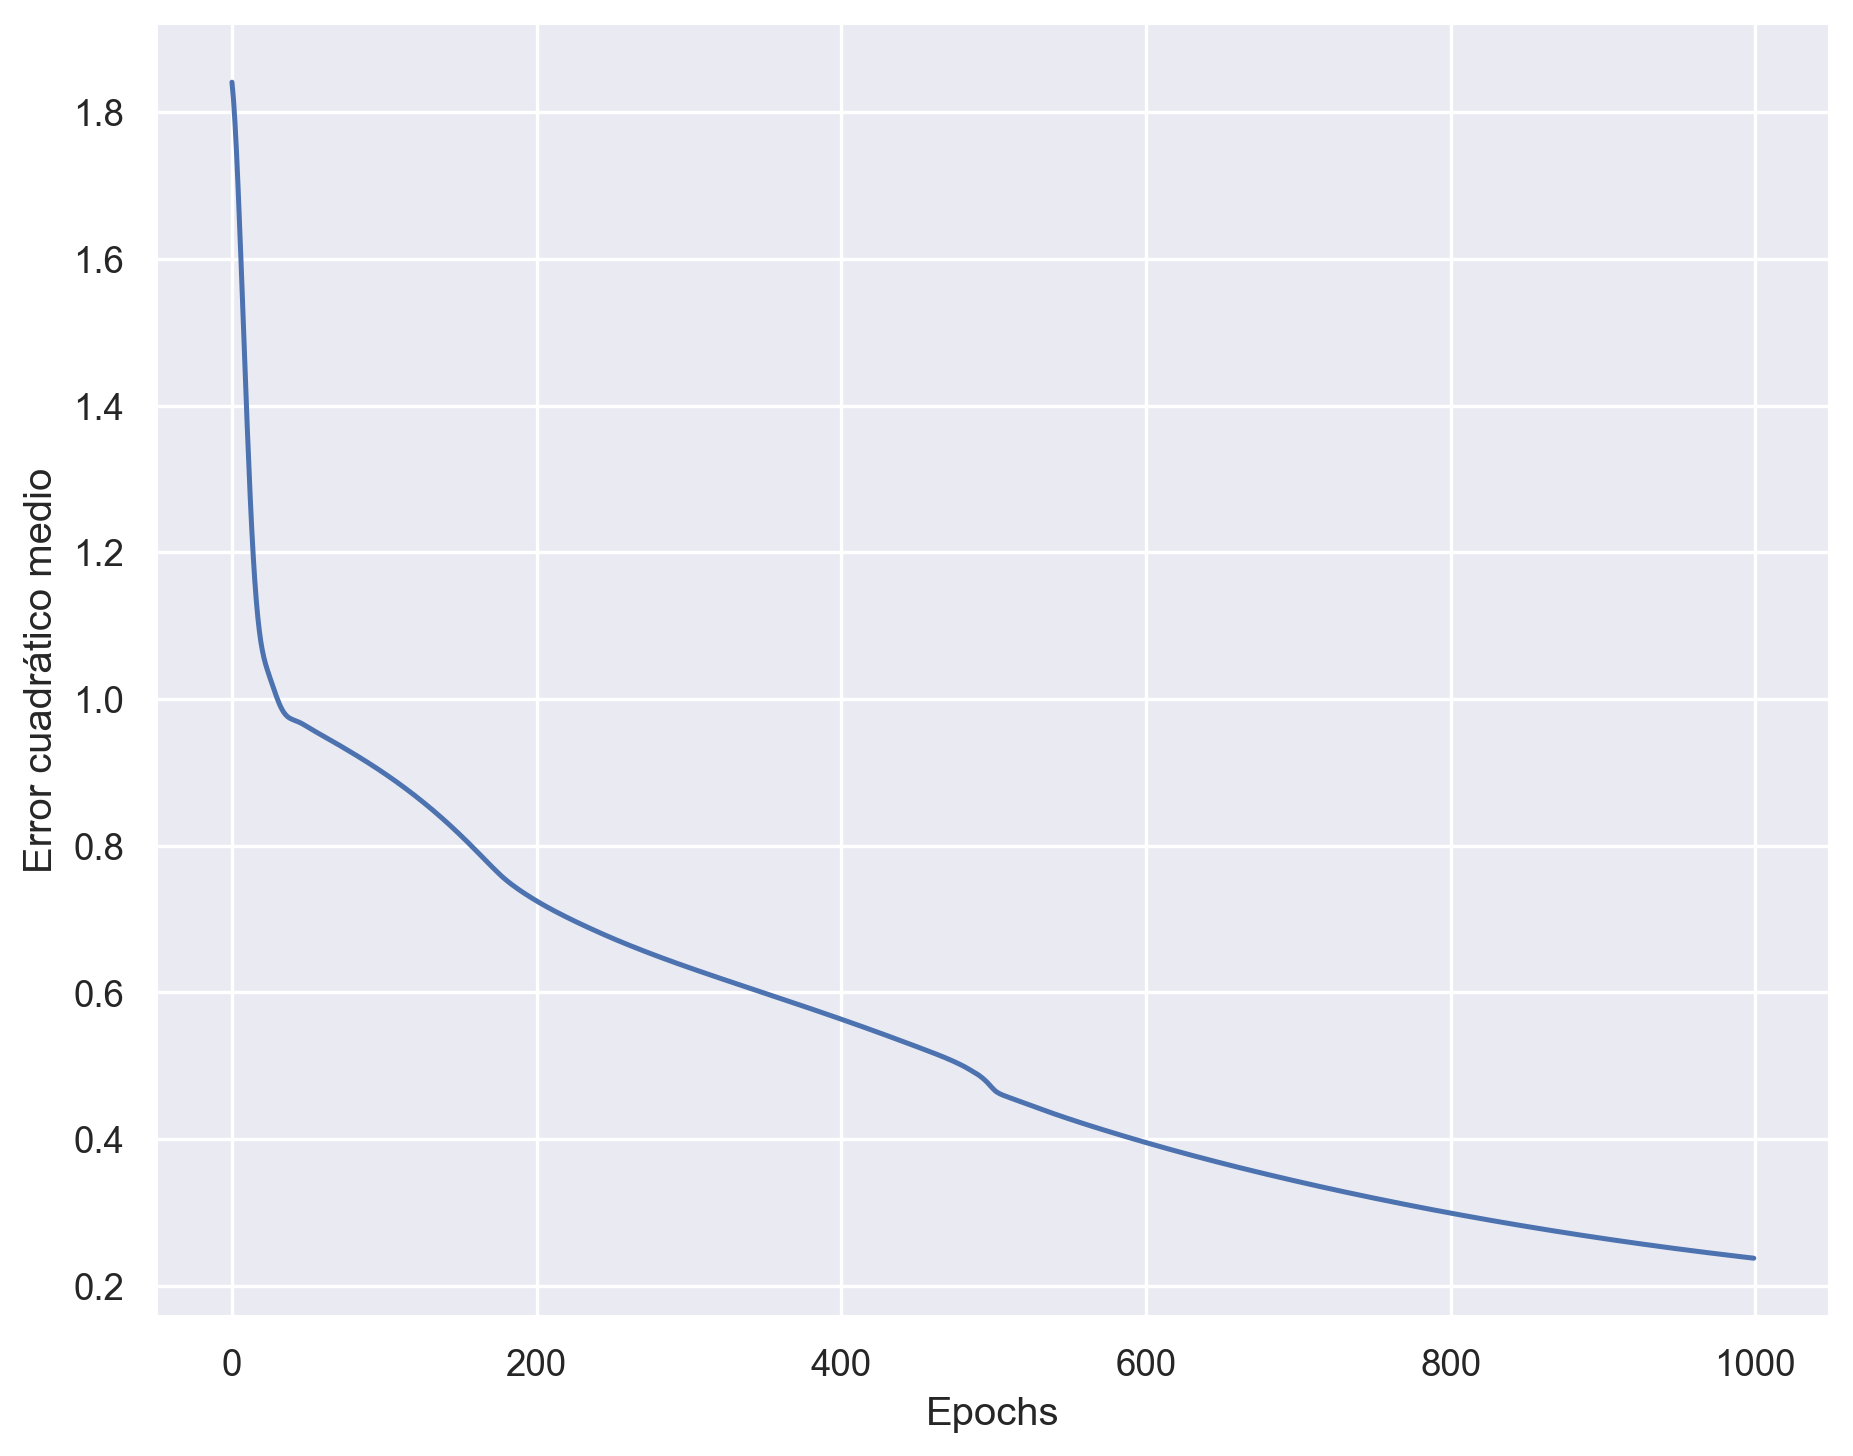

In [59]:
# Curva de la función de pérdida del clasificador.
plt.figure(dpi = 120)
plt.ylabel('Error cuadrático medio')
plt.xlabel('Epochs')
plt.plot(clf_iris.loss_curve_);

Evaluamos el desempeño del clasificador sobre el conjunto de datos:

In [60]:
clf_iris.score(X_iris, y_iris)

0.94

Visualizamos la superficie de decisión:

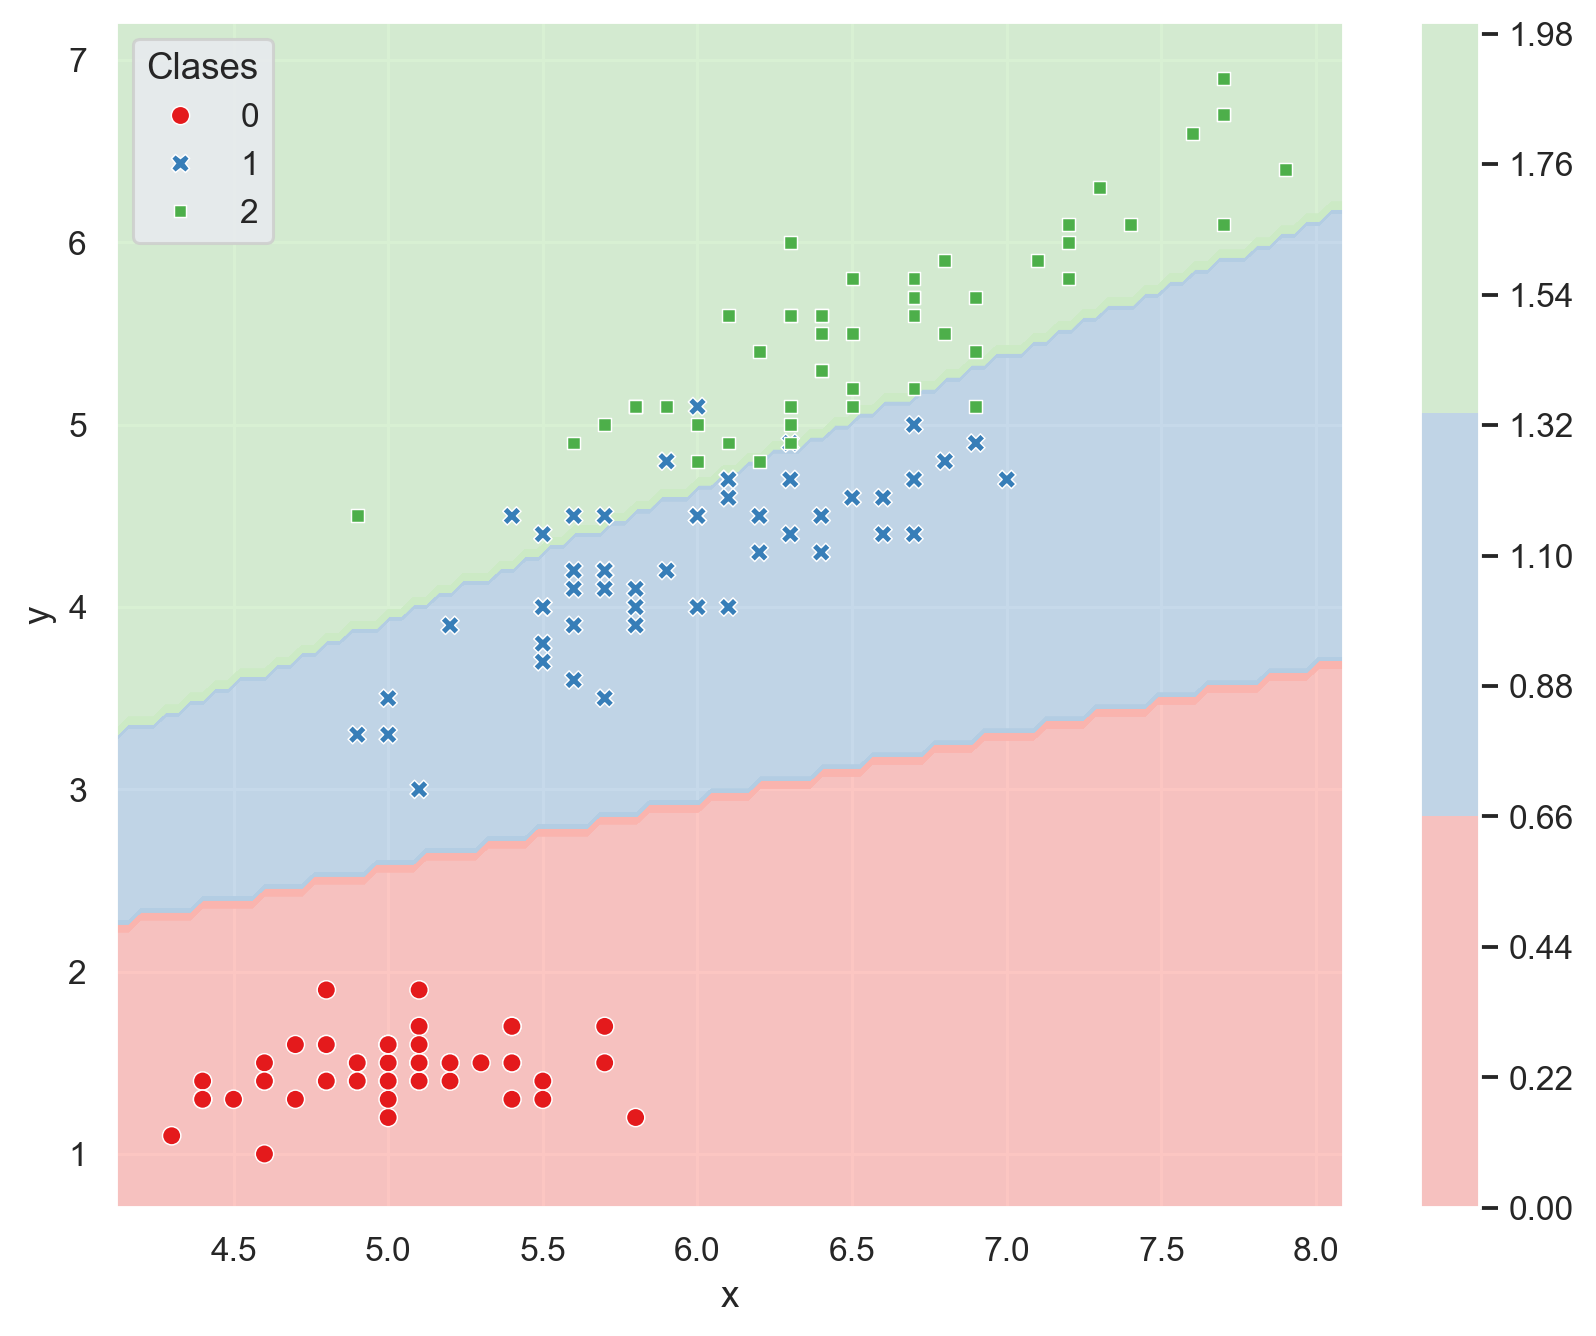

In [61]:
plot_data(X_iris, y_iris, clf_iris)

Ahora, realizaremos el mismo proceso con los datos del *dataset* **moons**.

In [62]:
# Clasificador para el conjunto moons
clf_moons = MLPClassifier(solver='lbfgs', # Método recomendado para datasets pequeños.
                    activation='tanh',    # Función de activación. En este caso se usa la función tangente hiperbólica, con valores entre -1 y 1.
                    max_iter=1000,        # Cantidad máxima de iteraciones permitidas
                    tol=1e-4, # Tolerancia de la optimización. Si en una iteración no mejora el modelo por esta cantidad (score) se detiene la ejecución.
                    hidden_layer_sizes=(3, 3)) # Número de neuronas por cada capa oculta.

In [63]:
# Entrenamiento del modelo. Este proceso puede tardar.
clf_moons.fit(X_moons, y_moons)
print(clf_moons.score(X_moons, y_moons))

0.995


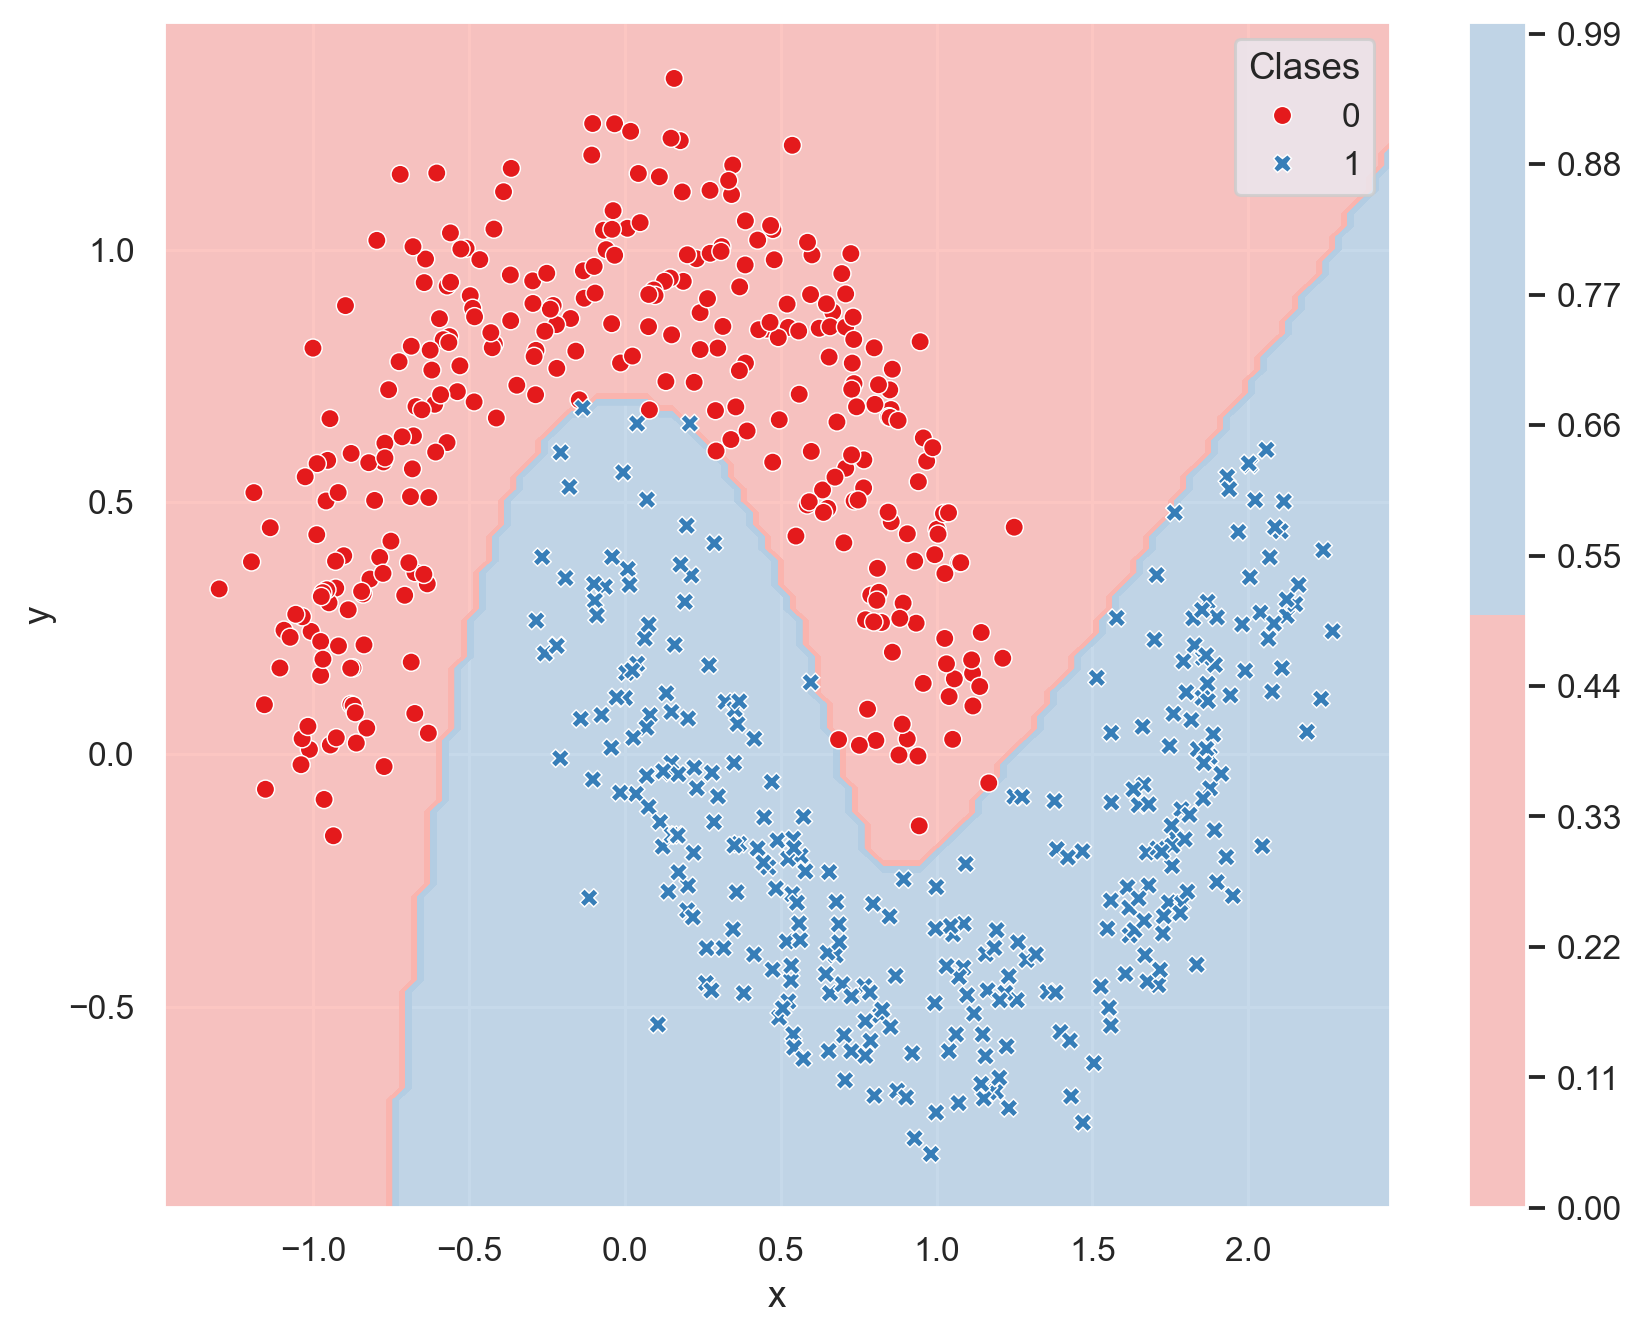

In [64]:
# Graficamos los resultados.
plot_data(X_moons, y_moons, clf_moons)

**`MLPClassifier`** también nos permite acceder a la matriz de parámetros $w$ y a los sesgos $w_0$. El atributo **`coefs_`** nos regresa una lista que corresponde a los parámetros aprendidos. A continuación, verificamos el tamaño de cada matriz y su respectivo valor:

In [65]:
print([a.shape for a in clf_moons.coefs_])
for coefs_row in clf_moons.coefs_:
  print(coefs_row)

[(2, 3), (3, 3), (3, 1)]
[[-5.97508659 -1.85108078 -1.84557949]
 [ 5.91331807 -0.55676587  0.25542838]]
[[ 4.97633329  6.06426497 -0.09918449]
 [-8.80620282 -3.98514666 -0.4974162 ]
 [ 6.95790727 -1.49390696  2.17308029]]
[[-13.99194012]
 [ -6.44924285]
 [ -2.94925278]]


Para acceder a los sesgos, se puede usar **`.intercepts_`**

In [66]:
print([a.shape for a in clf_moons.intercepts_])
for intercept in clf_moons.intercepts_:
  print(intercept)

[(3,), (3,), (1,)]
[ 7.67750466e+00  9.06677661e-01 -8.20146250e-04]
[-2.15928187  1.5915795  -1.87732854]
[2.13624041]


## **3.2. Ventajas y desventajas**
---

> **Ventajas**

* A través de las capas ocultas se pueden modelar relaciones de alto nivel entre las entradas. Por ejemplo, en el dominio de reconocimiento de objetos en imágenes, se puede aprender que el conjunto de dos ojos, una nariz y una boca forman la imagen de una cara.
* Las funciones de activación al ser no lineales le permiten al modelo aprender funciones de separación más elaboradas.

> **Desventajas**

La complejidad del modelo puede aumentar rápidamente con respecto al número de capas y de neuronas por capa. Contemple el caso de una red con las siguientes características:
* 1 capa de entrada de tamaño $50$.
* 1 capa oculta de $256$ neuronas.
* 1 capa oculta de $512$ neuronas.
* 1 capa de clasificación binaria.

Bajo esta configuración tenemos que el número de parámetros está distribuido de la siguiente manera:
* Conexiones entre la capa de entrada y la primera capa oculta: $256*50\ +\ 256 = 13056$. Donde la segunda parte corresponde a los sesgos.
* Conexiones entre la primera capa oculta y la segunda capa oculta: $256*512\ +\ 512 = 131584$.
* Conexiones entre la segunda capa oculta y la capa de clasificación: $512\ +\ 1 = 513$.
* Para un total de $145153$ parámetros entrenables.

> **Recomendaciones prácticas**

* Hacer un escalamiento de los datos de entrada. **`MLPClassifier`** es muy sensible a la escala de los datos de entrada.
* Explorar el número de neuronas por capa y el parámetro $\alpha$ usando **`GridSearchCV`**.
* Usar *lbfgs* como **`solver`** para conjuntos de datos pequeños. Mientras que *adam* es más recomendado para conjuntos de datos grandes.

# **4. Análisis de series de tiempo**
---

![texto alternativo](https://cdn-images-1.medium.com/max/800/1*ScwIEwLmXPFhBP46QMpy_A.png)

Las series de tiempo son una secuencia de observaciones indexadas por una variable temporal. Una de las aplicaciones más comunes del análisis de series de tiempo es la predicción de valores futuros utilizando datos históricos. Por ejemplo, se desea predecir el valor de la medida en el siguiente minuto, día, mes o año basados en los datos recolectados en los minutos, días, meses y/o años previos.




## **4.1 Validación cruzada para series de tiempo**
---

Un problema de análisis de series de tiempo puede ser transformado en un problema de aprendizaje supervisado tomando una **ventana** de  las $k$ observaciones anteriores como los datos de entrada o predictores y el valor actual como el valor objetivo o valor explicado. El ancho de la ventana $w$ normalmente se explora como un hiperparámetro.

Un aspecto importante a tener en cuenta en el análisis de series de tiempo es que la selección de los conjuntos de validación y entrenamiento para la validación cruzada o *cross validation* **no puede ser aleatorio** como se realiza en otros problemas de *machine learning* supervisado donde la secuencia y el tiempo no se toman en cuenta. En el análisis de series de tiempo estamos interesados en predecir un valor en el futuro. De esta manera, los datos de validación para series de tiempo siempre deben ocurrir temporalmente después de los datos de entrenamiento. Existen dos esquemas de validación cruzada para series de tiempo **_sliding window_** y **_forward chaining validation_** que pueden ser usados para la validación cruzada de series de tiempo.

![texto alternativo](https://cdn-images-1.medium.com/max/800/1*h6HaTi1DKsNqEUjdECQV0A.png)



## **4.2. Series de tiempo con redes neuronales artificiales**
---

Ahora realizaremos la predicción para el *dataset* de temperaturas mínimas medias semanales. Carguemos nuevamente el objeto *Series*.

In [68]:
# Objeto Series con el conjunto de datos.
url = 'https://drive.google.com/uc?export=download&id=1XvKsdBs6EG463iN3L1lQv9JXd9lW0JJC'

mintemp = pd.read_csv(url, index_col = 0, parse_dates= True)
mintemp.squeeze()
mintemp.head()

,Temp
Date,
1981-01-01,20.700000
1981-01-08,16.585714
1981-01-15,19.214286
1981-01-22,18.514286
1981-01-29,16.814286


In [69]:
# Información general del contenido de la serie.
mintemp.describe()

,Temp
count,523.000000
mean,11.197683
std,3.430824
min,2.742857
25%,8.700000
50%,11.057143
75%,13.821429
max,20.700000


Vamos a visualizar la serie de los valores de temperatura. Este será el valor que predeciremos.

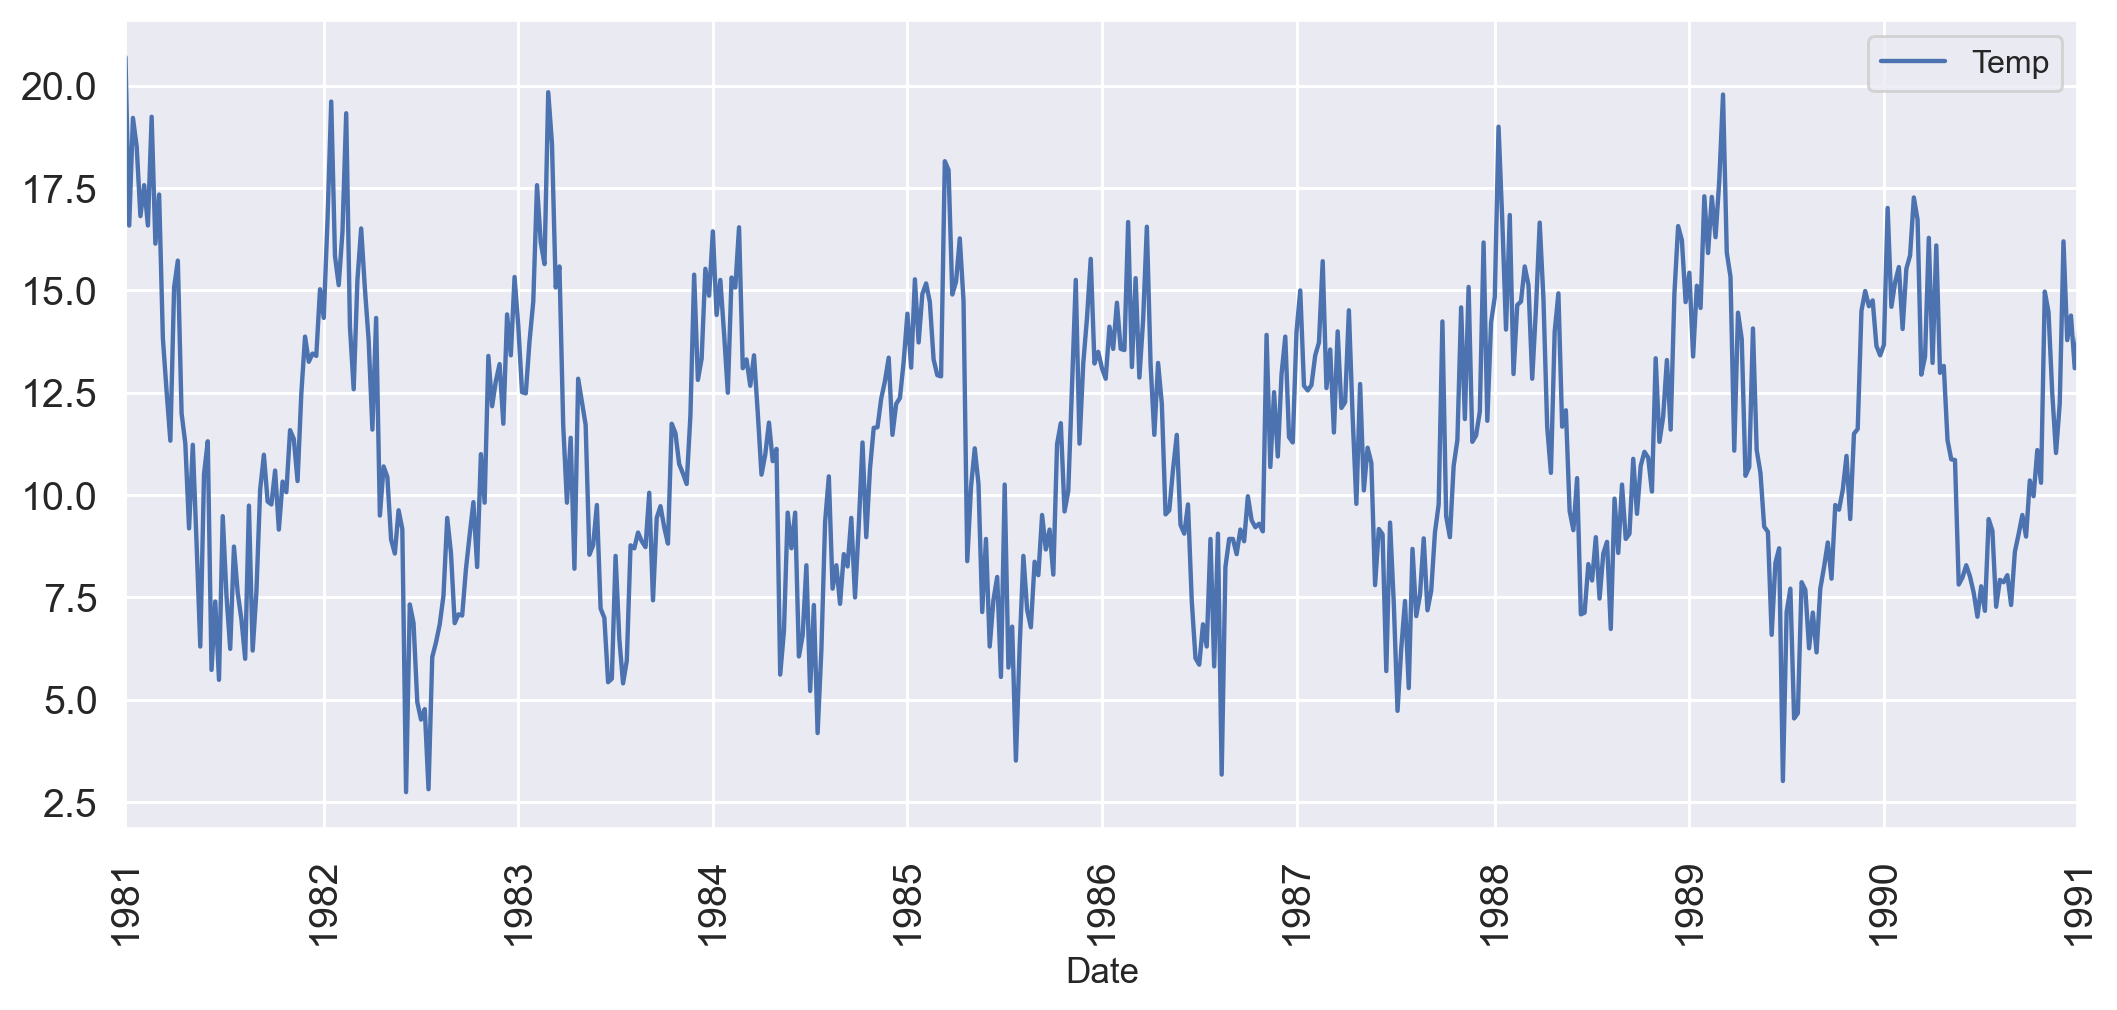

In [70]:
mintemp.plot(rot=90, figsize = (12, 5), fontsize = 13.5);

Vamos a preparar el *dataset* para el modelado. Nuestro objetivo es entrenar un **modelo autorregresivo**, en el cual el valor de la serie de tiempo en un momento dado $X_i$ depende de los $k$ valores anteriores.

La red neuronal debe tener $k$ entradas o *features* y $1$ salida, que corresponde al valor actual. Las *features* serán las $k$ observaciones previas, que corresponden a una **ventana** de tamaño $k$.

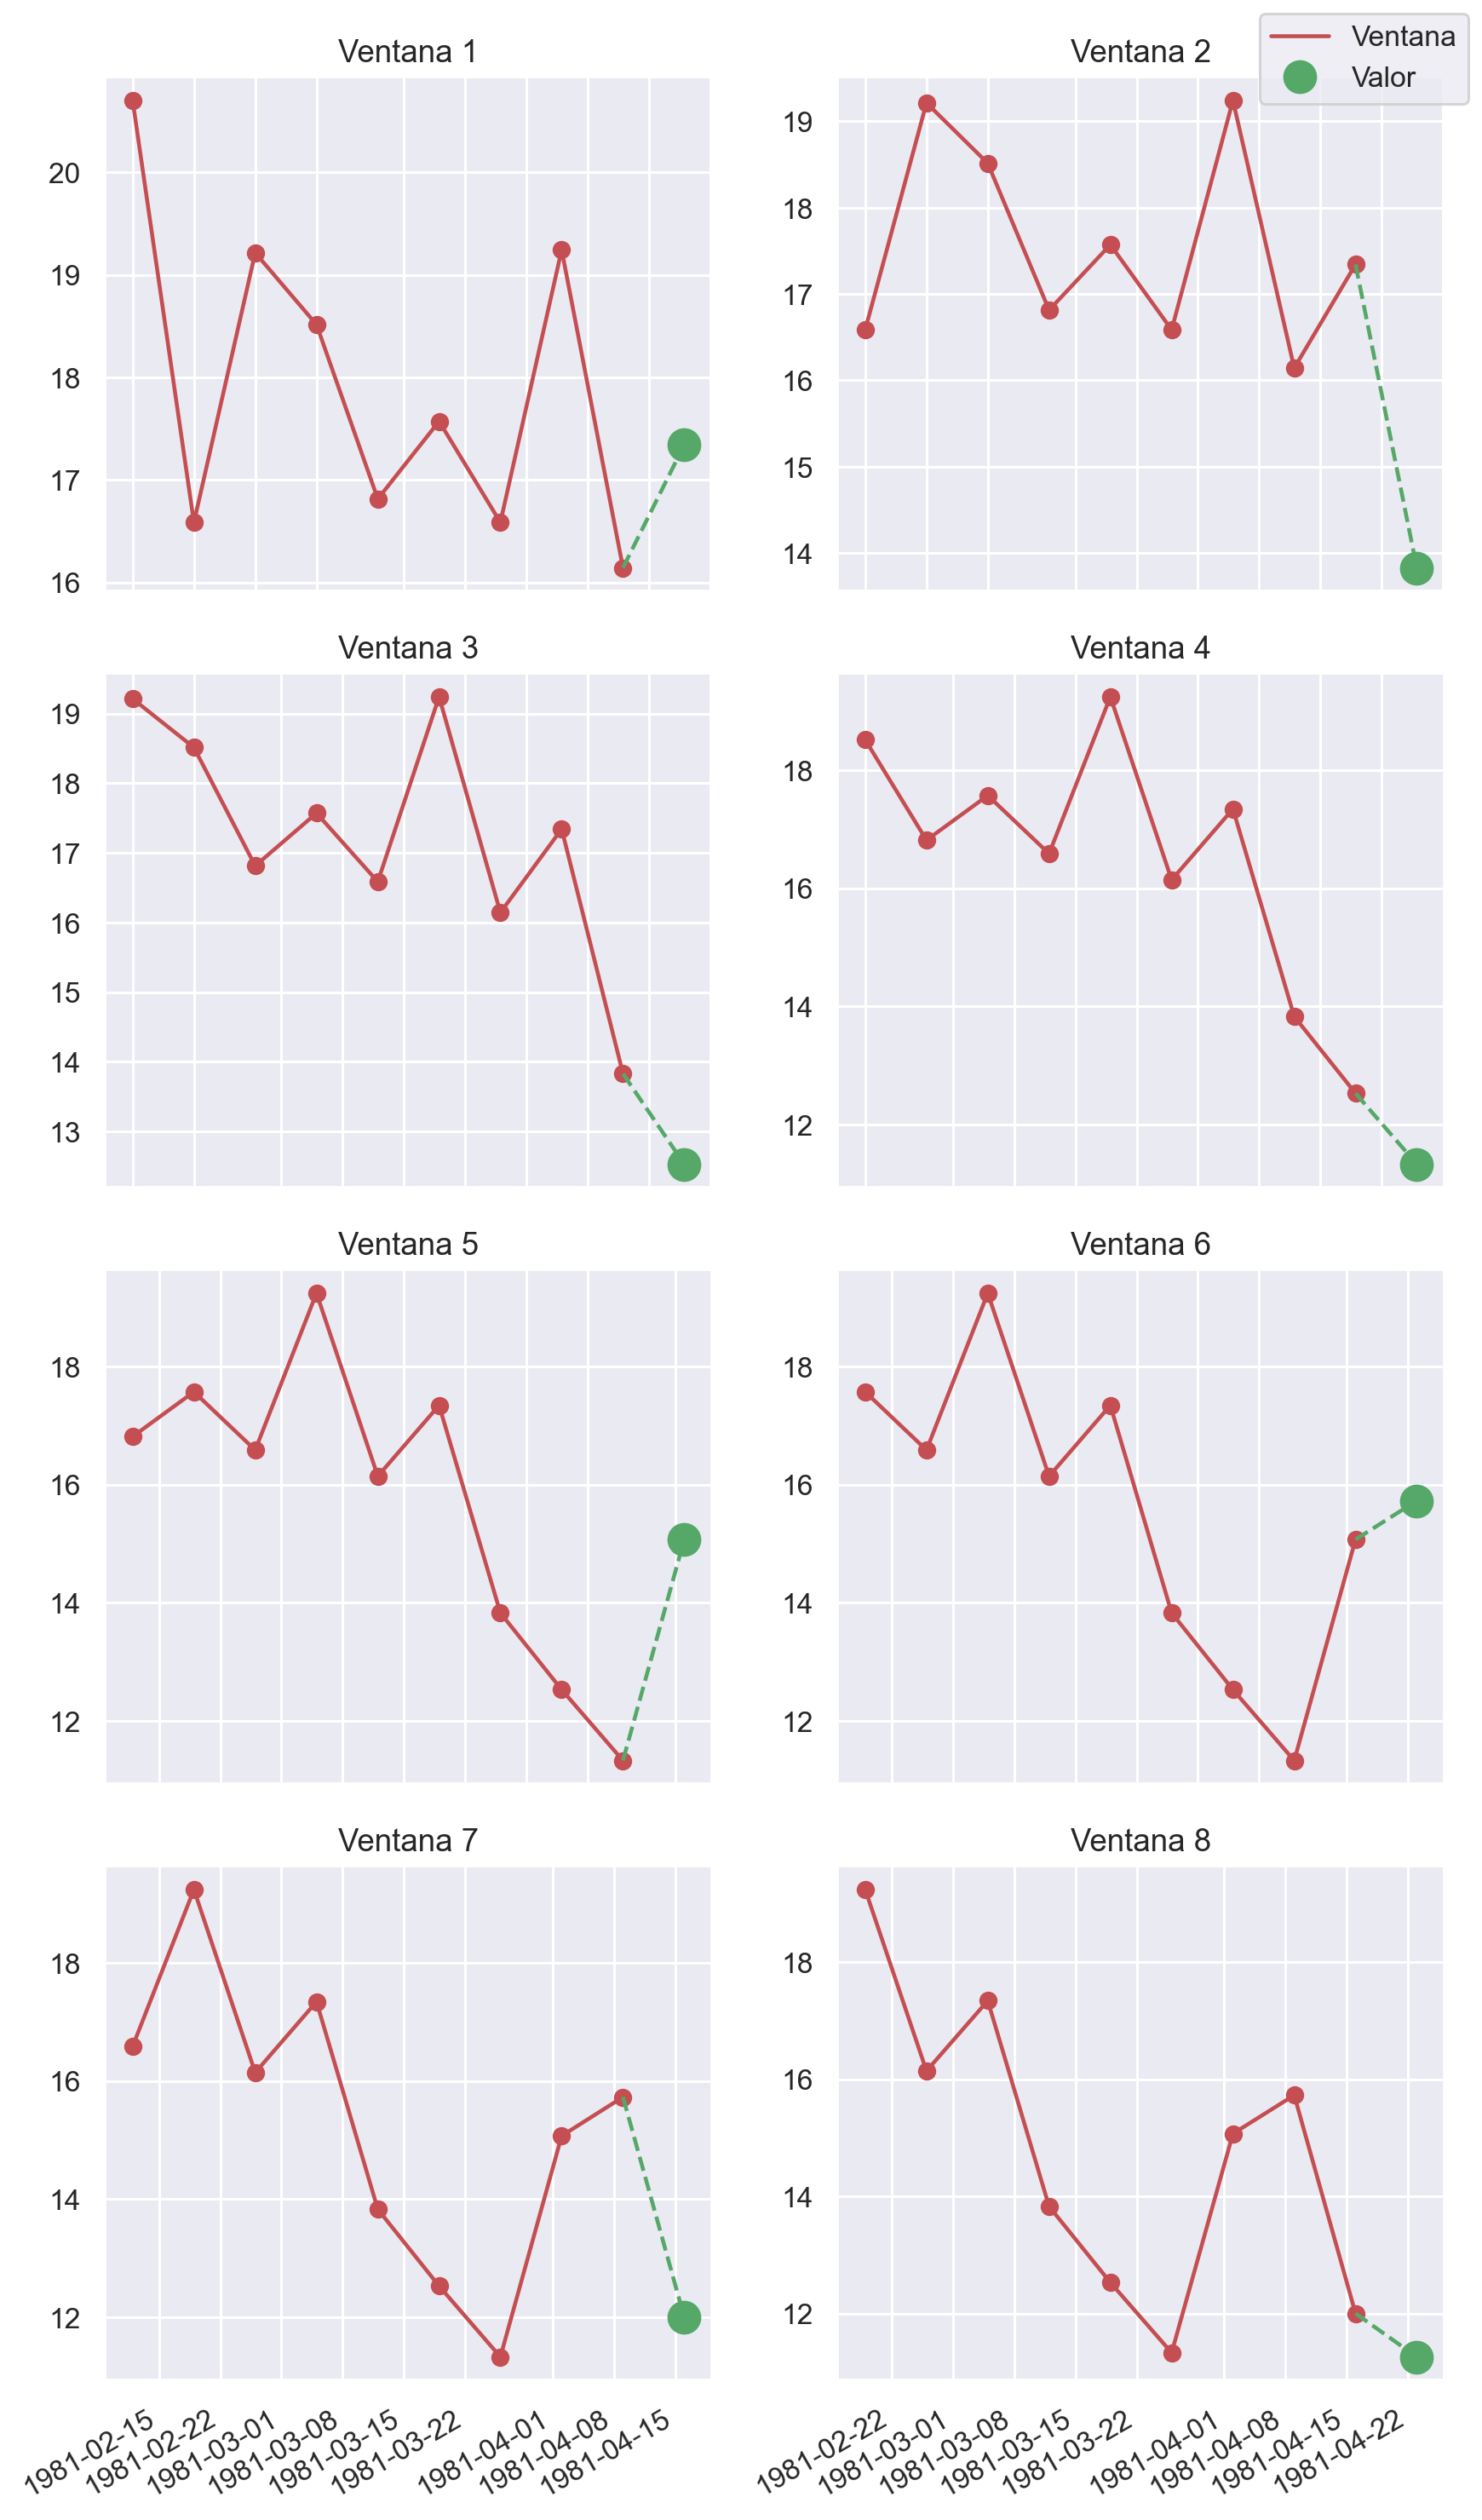

In [71]:
#@markdown **Visualización:** demostración del concepto de ventanas de tiempo.

#@markdown * **`n`**: Número de ventanas a visualizar.
n =   9#@param {type:"integer"}
#Visualización del concepto de ventana

#@markdown * **`k`**: Tamaño de la ventana.
k =   10#@param {type:"integer"}

fig, axes = plt.subplots(nrows = n//2, ncols= 2,  figsize = (8, 1.5*n), dpi = 110)

for i, ax in enumerate(axes.flat):
  data =  mintemp.iloc[i: i + k]
  ax.set_title(f'Ventana {i + 1}')
  ax.plot(data.index[:-1], data.values[:-1], 'r')
  ax.plot(data.index[-1], data.values[-1], 'go', ms = 12)
  ax.plot(data.index[:-1], data.values[:-1], 'ro')
  ax.plot(data.index[-2:], data.values[-2:], 'g--')
  fig.autofmt_xdate()
fig.tight_layout()

fig.legend(['Ventana', 'Valor']);

Para generar nuestro modelo vamos a iniciar con una ventana de tiempo de $20$ observaciones.

In [72]:
# Tamaño de la ventana. Puede cambiarlo si lo desea.
# Tenga en cuenta que el entrenamiento para valores mayores tardará más tiempo.

k = 20

Usaremos los registros de los primeros $7$ años del dataset (desde $1981$ hasta $1986$) para el conjunto de entrenamiento y validación y los siguientes $2$ (desde $1987$ hasta $1990$) para el conjunto de pruebas. Empezamos almacenándolos en arreglos de _NumPy_.

In [73]:
data_train = mintemp.loc[:'1986-12-31']  # Primeros 7 años
data_test  = mintemp.loc['1987-01-01':]  # Últimos 3 años.

data_train.index[-1], data_test.index[0] # Fechas de inicio de ambos conjuntos.

(Timestamp('1986-12-25 00:00:00'), Timestamp('1987-01-01 00:00:00'))

In [74]:
# Función para obtener las ventanas de tiempo.

def sliding_time(ts, window_size=1):

  n = ts.shape[0] - window_size
  X = np.empty((n, window_size))
  y = np.empty(n)

  for i in range(window_size, ts.shape[0]):
    y[i - window_size] = ts[i]
    X[i- window_size, 0:window_size] = np.array(ts[i - window_size:i])

  return X, y

In [77]:
# Creamos las ventanas y sus valores a predecir para entrenamiento y validación.

X_train, y_train = sliding_time(data_train.values, window_size=k)

ValueError: could not broadcast input array from shape (20,1) into shape (20,)

In [76]:
print(f"Número de ejemplos de entrenamiento: {X_train.shape[0]} (Ventana de tamaño {X_train.shape[1]})")
print(f"Número de valores a predecir: {y_train.shape[0]}")

NameError: name 'X_train' is not defined

In [ ]:
# Creamos las ventanas y sus valores a predecir para entrenamiento y validación.
X_test, y_test = sliding_time(data_test.values, window_size=k)

In [ ]:
print(f"Número de ejemplos de entrenamiento: {X_test.shape[0]} (Ventana de tamaño {X_test.shape[1]})")
print(f"Número de valores a predecir: {y_test.shape[0]}")

La fila $X_i$ de $X$ corresponde a una ventana de los $k$ valores anteriores a $y_i$. En la siguiente celda podemos ver el arreglo en formato de *DataFrame*. Note que cada fila es la fila anterior corrida un movimiento hacia la izquierda.

In [ ]:
# Observaciones de X en formato de DataFrame.
pd.DataFrame(X_train)

En $y_i$ está el elemento que iría justo después del último valor de la ventana $X_i$. Note que el elemento $y_i$ es el último valor de la fila $X_{i+1}$, pues en esa ventana pasa a ser el último elemento, usado para predecir el valor $y_{i+1}$.

In [ ]:
# Valores a predecir y en formato de Series.
pd.Series(y_train)

### **4.2.1. Partición de los datos de entrenamiento y pruebas**
---

Como se mencionó previamente, para realizar la partición de entrenamiento y pruebas se debe tomar en cuenta la temporalidad de la serie. Para ello utilizaremos la función **`TimeSeriesSplit`** de *Scikit-Learn*.

In [ ]:
# Selección de los datos en series de tiempo
from sklearn.model_selection import TimeSeriesSplit

# Definimos el número de splits para realizar cross-validation
tsp = TimeSeriesSplit(n_splits=3)

EL método **`TimeSeriesSplit`** toma como parámetro los arreglos **`X`** y **`y`** y genera los índices para entrenamiento y pruebas de una validación cruzada de _**forward chaining**_ igual a la cantidad de divisiones definidas en el argumento **`n_splits`**.

In [ ]:
for i, (train_index, test_index) in enumerate(tsp.split(X_train, y_train)):

  print(f'-------------------- Pliegue {i + 1} --------------------')
  print("\tPartición de entrenamiento")
  print(f'\t\tTamaño de la partición: {train_index.shape}')
  print(f'\t\tRango de valores: {train_index[0]}-{train_index[-1]}\n')

  print("\tPartición de validación")
  print(f'\t\tTamaño de la partición: {test_index.shape}')
  print(f'\t\tRango de valores: {test_index[0]}-{test_index[-1]}\n')

In [ ]:
#@markdown **Visualización:** demostración de la ubicación de los índices de la partición de series de tiempo con **`TimeSeriesSplit`**.


n_splits = 3 #@param {type:"slider", min:3, max:7, step:1}

# La partición nos devuelve los indices de train y test.
tsp = TimeSeriesSplit(n_splits=n_splits)

i = 0
fig = plt.figure(figsize = (12,6), dpi = 110)
plt.set_cmap('Paired')

tsp_indexes = [(train_index, test_index) for (train_index, test_index) in tsp.split(X_train, y_train)]

for train_index, test_index in tsp_indexes:
  plt.plot(train_index,
           np.full(len(train_index), 1-i*0.001),
           lw = 8,
           ls= '-.',
           label = f'Entrenamiento (k = {i + 1})')

  plt.plot(test_index,
           np.full(len(test_index), 1-i*0.001),
           lw = 8,
           ls= '-',
           label = f'Validación (k = {i + 1})')
  i+=1
fig.get_axes()[0].get_yaxis().set_visible(False)
plt.legend(ncol=1, title = 'Índices por partición', );

Visualizamos los datos de entrenamiento y validación de esta última división:

In [ ]:
# Datos de prueba y entrenamiento con Matplotlib
train_index, test_index = tsp_indexes[-1]

fig = plt.figure(dpi = 120, figsize = (8, 3))
plt.plot(mintemp[train_index].index, mintemp[train_index].values, label = "Entrenamiento (y)")
plt.plot(mintemp[test_index].index, mintemp[test_index].values, label = "Prueba (y)")

plt.title('Datos de entrenamiento y pruebas (y)')
fig.autofmt_xdate()

## **4.3. Regresión de series de tiempo con perceptrón multicapa**
---
Ahora realizamos la regresión con una red neuronal multicapa, para predecir el valor de la serie. En esta ocasión utilizaremos **`MPLRegressor`**. Sus parámetros son equivalentes a los aceptados por **`MLPClassifier`**, a diferencia que el regresor permite retornar los valores continuos generados por la función de predicción.

In [ ]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(solver = 'lbfgs',
                   activation = 'relu',
                   hidden_layer_sizes=(120, 60, 30),
                   max_iter=200,
                   n_iter_no_change=50,
                   validation_fraction=0.2,
                   random_state=1234)

In [ ]:
# Entrenamos el modelo.
model.fit(X_train, y_train)

In [ ]:
# Métricas de rendimiento
# Error absoluto, cuadrado, y cuadrado logarítmico.
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

y_pred = model.predict(X_test)

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_pred):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_pred):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_pred):.4f}")

In [ ]:
x = data_test.index[k:]

plt.figure(figsize=(10,3), dpi = 105)
plt.plot(x, y_test, ls = "--", label="Valor verdadero (pruebas)")
plt.plot(x, y_pred, ls = '-', label="Valor predicho (pruebas)")
plt.title("Predicción vs valores verdaderos (pruebas)")
plt.legend();

### **4.3.1. Validación cruzada con series de tiempo**
---
Ahora vamos a explorar los hiperparámetros de la red para identificar sus valores más apropiados. Para hacer esto, utilizaremos todas las particiones generadas por **`TimeSeriesSplit`** y exploraremos manualmente las combinaciones de hiperparámetros de **`MLPRegressor`**.

En este ejemplo exploraremos el tamaño de la capa oculta (**`hidden_layer_sizes`**) y la función de activación (**`activation`**).

In [ ]:
params = {
      'hidden_layer_sizes' : [(10,), (20,), (40,), (80,) ], # Algunas arquitecturas propuestas.
      'activation' : ['logistic', 'tanh', 'relu']           # Funciones de activación.
 }

El objeto generado por **`TimeSeriesSplit`** puede ser usado para generar las particiones de validación cruzada con el método **`GridSearchCV`**, pasándolo con el argumento **`cv`**.

> **Nota**: La búsqueda explora $12$ configuraciones distintas en cada uno de los $5$ pliegues generados  con **`TimeSeriesSplit`**. Como consecuencia la función puede tardar unos minutos en ejecutarse por completo.

In [ ]:
#Grid Search para el modelo MLPRegressor
from sklearn.model_selection import GridSearchCV

tsp = TimeSeriesSplit(n_splits = 5)

gsearch = GridSearchCV(estimator = MLPRegressor(solver = 'lbfgs', #Modelo  a explorar.
                                                random_state=1234,
                                                max_iter= 2000,
                                                n_iter_no_change=50,
                                                validation_fraction=0.2),
                        cv = tsp,
                        param_grid = params,
                        verbose = 3)

gsearch.fit(X_train, y_train)

Finalmente, podemos explorar el objeto generado en busca de la mejor configuración identificada, como se realizó en el material anterior.

In [ ]:
# Los mejores 10 modelos con respecto a su mean_test_score.
pd.DataFrame(gsearch.cv_results_).nlargest(10, 'mean_test_score')

Finalmente, para la evaluación del modelo en la tarea de predecir instancias futuras, podemos retroalimentar los datos predichos en nuevas ventanas que se usen para predecir datos totalmente generados por el modelo.

A continuación, vamos a realizar este proceso desde la primera ventana del conjunto de evaluación, y comparar los resultados con los valores obtenidos al predecir a partir de las ventanas de evaluación y con los datos reales.

 Las líneas generadas en la visualización tienen el siguiente significado:
  * **Valores de entrenamiento y pruebas**: La primera ventana de tiempo
      (<font color="blue"><b>en azul</b></font>) corresponde a los datos que fueron usados para entrenar y validar el desempeño del modelo. A partir de su último valor se realizan las predicciones correspondientes.
  * **Valores reales**: Esta línea (<font color="red"><b>en rojo</b></font>) corresponde a los valores reales de la ventana de tiempo final en el conjunto de datos original. Se visualiza para realizar una comparación gráfica con los valores predichos por el modelo.
  * **Valores predichos a partir de datos reales**: Esta línea (<font color="green"><b>en verde</b></font>) corresponde a los valores predichos por el modelo a partir de la ventana previa de valores reales, aunque su final no coincida con el valor predicho con la ventana inmediatamente anterior.
  * **Valores predichos a partir de datos predichos**: Esta línea (<font color="BlueViolet"><b>en azul</b></font>) corresponde a los valores predichos por el modelo a partir de la ventana previa de valores construida a partir de predicciones continuas. Al inicio se realiza una predicción con los valores reales del final de la primera ventana de tiempo y se concatena el valor predicho al final de la nueva ventana usada para predecir. Gracias a esta configuración se podría realizar teóricamente una lista de predicciones sin límite.

In [ ]:
#@markdown **Visualización:** Visualización de los resultados de la regresión a partir de datos reales y predichos
#@markdown > **Nota**: La función es generada con la librería de visualización interactiva de datos [*Plotly*](https://plotly.com/python/). Use la rueda del ratón para hacer *zoom* y haga clic y arrastre el puntero para desplazarse en los posibles valores.
# Últimos valores de entrenamiento a usar para la predicción.
X_last = X_test[:1]

# Listas con los datos en y, empezando desde el primer valor de pruebas.
y_last = []
y_forward = []

for i in range(len(X_test)):
  # Valores predichos a partir de datos reales (X_test)
  y_pred_forward = gsearch.predict(X_test[i: i + 1])
  y_forward.append(y_pred_forward[0])

  # Valores predichos a partir de datos predichos y retroalimentados.
  y_pred_last = gsearch.predict(X_last)  # Se predice el valor siguiente a partir de datos predichos previamente.
  y_last.append(y_pred_last[0])          # Guardamos el valor predicho.

  # Creación de la nueva ventana añadiendo la última predicción.
  X_last = np.roll(X_last, -1)           # Desplazamos todos los valores hacia la izquierda con np.roll
  X_last[0,-1] = y_pred_last             # Guardamos el valor predicho en la última posición del arreglo.

#Gráficamos las 2 predicciones distintas en comparación con los valores reales.

test_date_index = data_test.index[k:]
plot_prediction(gsearch.best_params_,
                (y_test, y_forward, y_last),
                 test_date_index)

Podemos utilizar métricas para evaluar el rendimiento obtenido con los dos métodos. El segundo método, aun usando datos predichos únicamente, produce un resultado bastante bueno con relación a la poca información real de la que parte para su construcción.

In [ ]:
# Datos predichos a partir de datos predichos.

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_last):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_last):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_last):.4f}")

In [ ]:
# Datos predichos a partir de datos reales.

print(f"Test Mean Squared Error: \t{mean_squared_error(y_test, y_forward):.4f}")
print(f"Test Mean Absolute Error: \t{mean_absolute_error(y_test, y_forward):.4f}")
print(f"Test Mean squared log error: \t{mean_squared_log_error(y_test, y_forward):.4f}")

# **Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de la librería *Scikit-learn* en la creación y entrenamiento de redes neuronales multicapa y el análisis y modelado de problemas de series de tiempo, además de material de apoyo teórico para reforzar estos conceptos:

* [Time Series Machine Learning Regression Framework](https://towardsdatascience.com/time-series-machine-learning-regression-framework-9ea33929009a)
* [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)
* [Analytics Vidhya - Time Series Forecasting using Python](https://courses.analyticsvidhya.com/courses/creating-time-series-forecast-using-python/)
* [3Blue1Brown - Neural Networks (Lista de reproducción de *YouTube*)](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
* [Fernando Sancho Caparrini - Redes Neuronales: una visión superficial.](http://www.cs.us.es/~fsancho/?e=72)
* [Knut Hinkelmann - Neural Networks](http://didattica.cs.unicam.it/lib/exe/fetch.php?media=didattica:magistrale:kebi:ay_1718:ke-11_neural_networks.pdf)
* [MIT Press book - Deep learning book](https://www.deeplearningbook.org/)
* [course.fast.ai](https://course.fast.ai/)





# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:**
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*